In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from dataprep.eda import create_report, plot, plot_correlation, plot_missing , plot_diff
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, median_absolute_error
import plotly.express as px

from lightgbm import LGBMClassifier, log_evaluation, LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from optuna.integration import CatBoostPruningCallback
from sklearn.base import BaseEstimator, TransformerMixin

import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import optuna
import numpy as np

In [2]:
df = pd.read_csv('train.csv')
# og = pd.read_csv('original.csv')
test_df = pd.read_csv('test.csv')
df.shape, test_df.shape

((10407, 13), (6939, 12))

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,10407.0,5203.000000,3004.386460,0.0,2601.500000,5203.000000,7804.500000,10406.000000
allelectrons_Total,10407.0,128.053516,224.123776,0.0,68.000000,100.000000,131.000000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,7.558488,10.650000,16.676996,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,10.000000,12.600000,22.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,4.000000,4.714286,4.800000,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,20.298893,26.203827,48.719500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,10.590660,11.202760,11.670725,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.672500,1.732727,1.800000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.864000,0.915556,0.981667,1.615840


In [8]:
df.drop('id',axis=1, inplace=True)
test_df.drop('id',axis=1, inplace=True)

In [9]:
features = [f for f in df.columns if f!= 'Hardness']
features

['allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average']

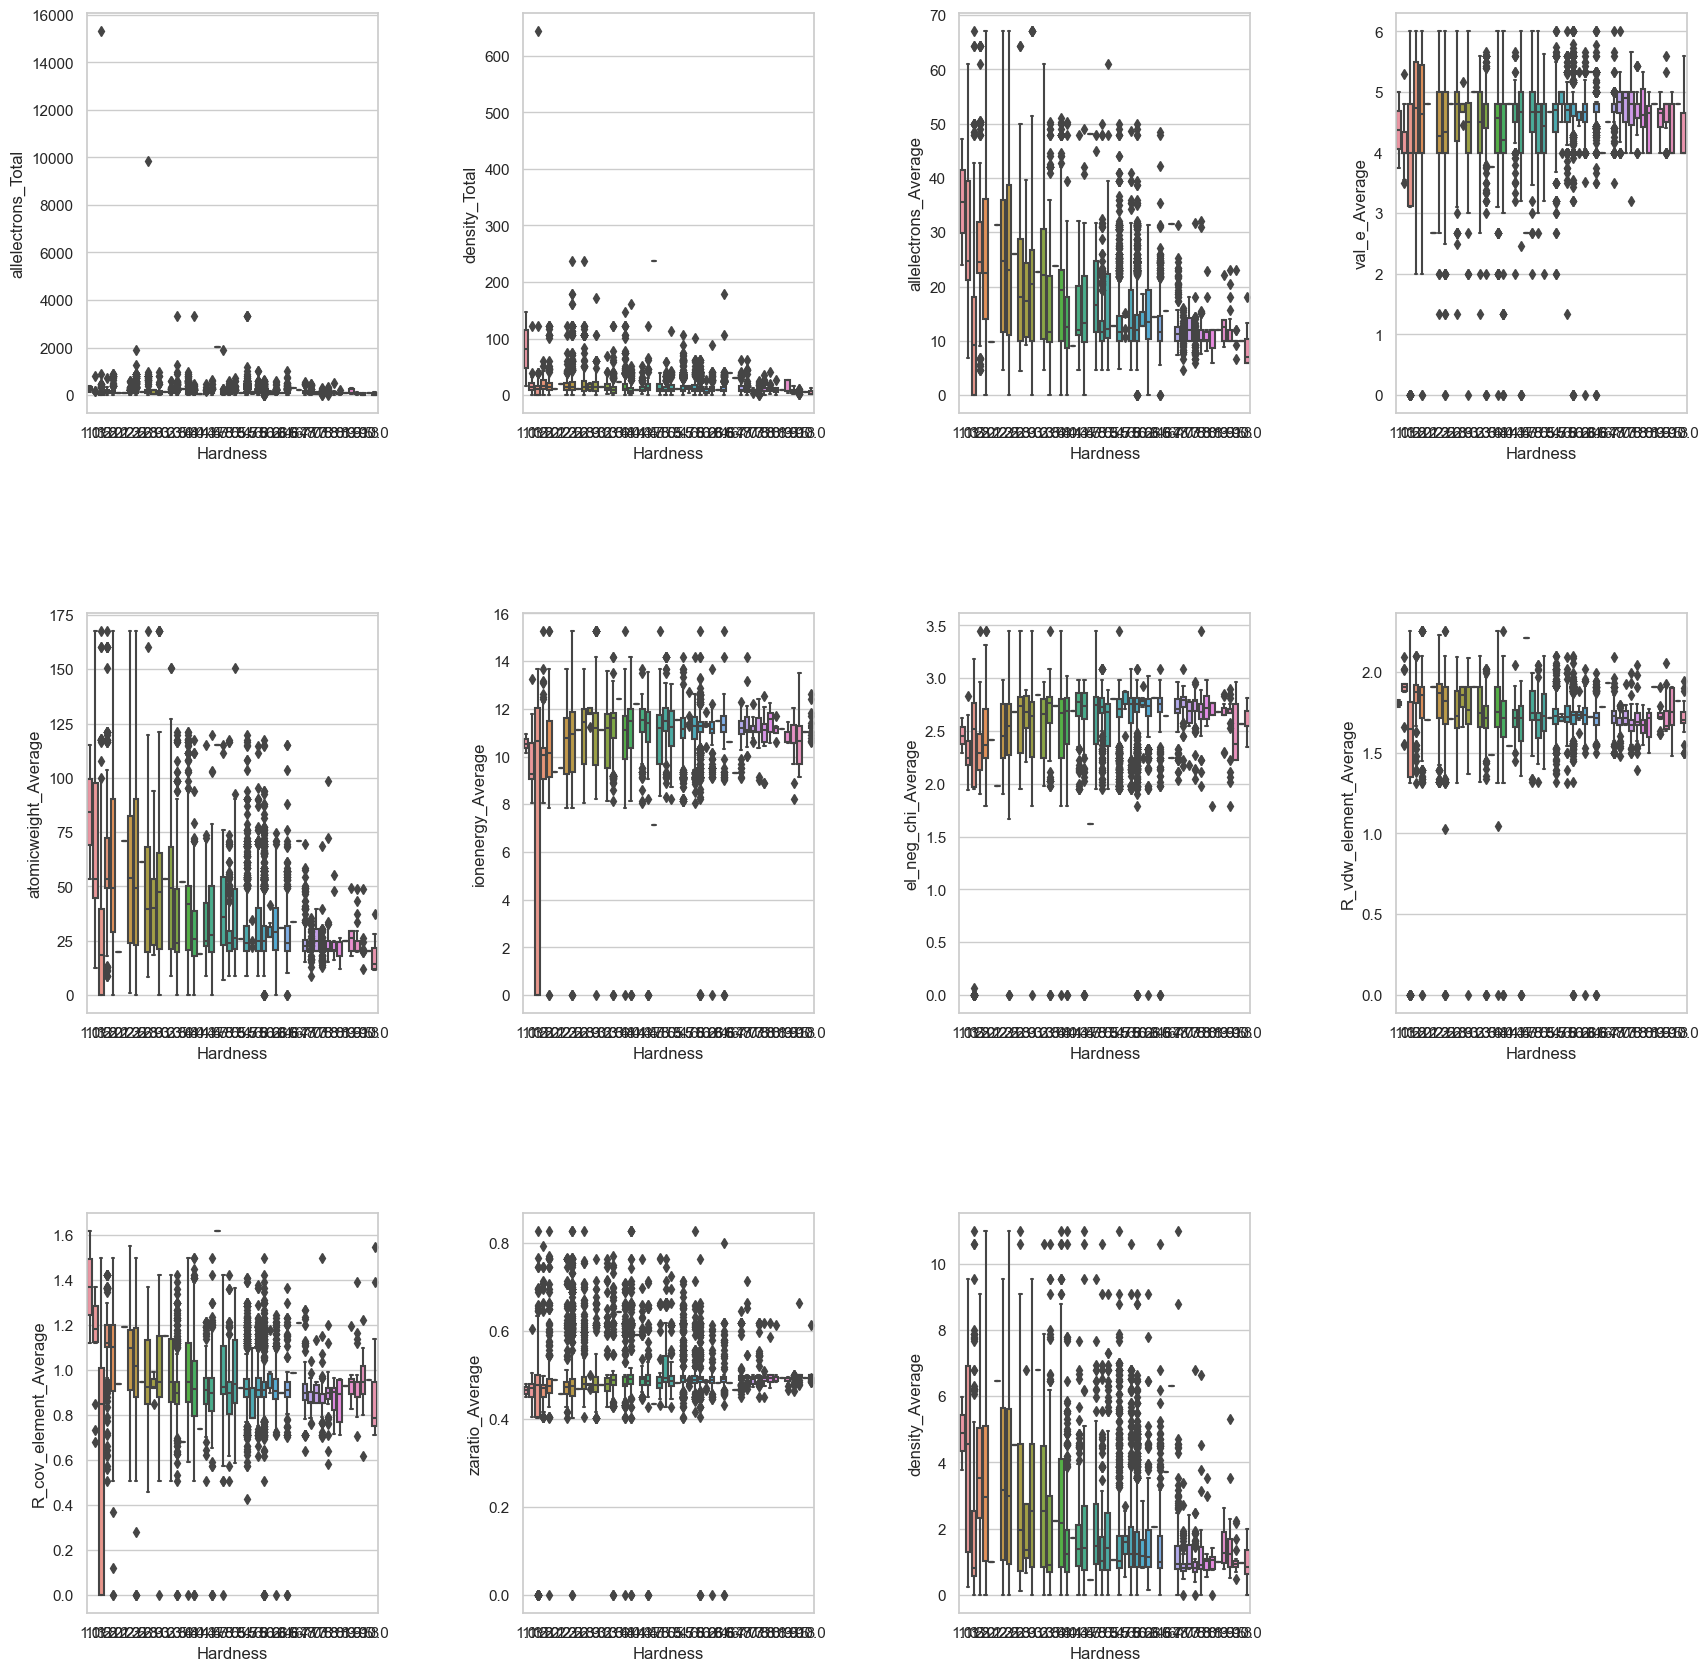

In [16]:
# Set the figure size
plt.figure(figsize=(20, 20))
sns.set_theme(style="whitegrid")
# Create categorical features subplots
for i, feature in enumerate(features):
    ax = plt.subplot(3, 4, i+1)
    sns.boxplot(x="Hardness", y=feature , data=df, ax=ax)
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=.5, wspace=0.5)

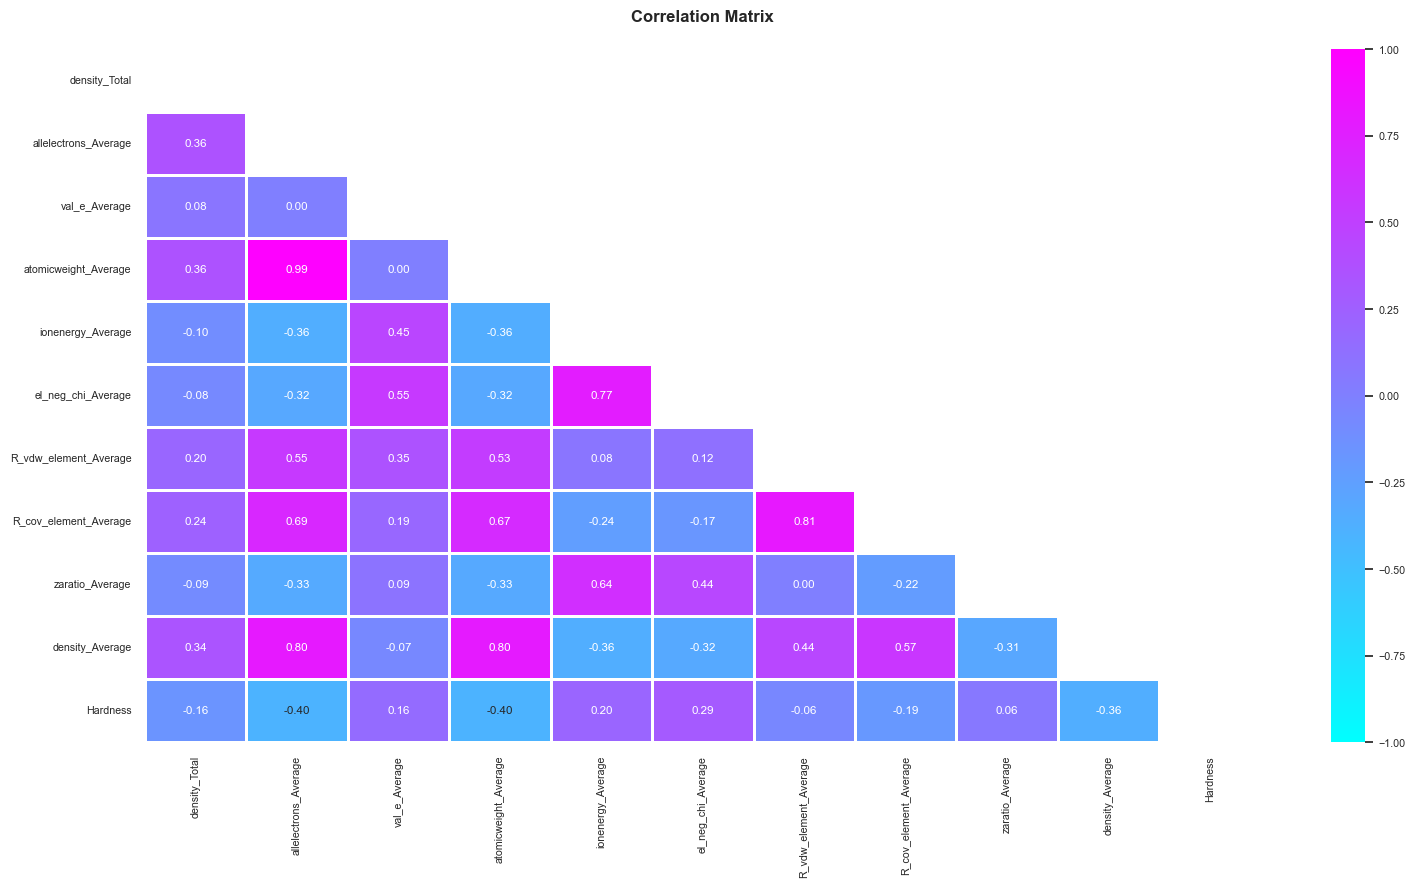

In [17]:
corr = df.iloc[:,1:].corr()

# create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create heatmap
plt.figure(figsize=(18, 9))
# set theme to change overall style
sns.set_theme(style="white", font_scale=0.7)
sns.heatmap(corr, cmap="cool", linewidths=2, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation Matrix", fontsize=12, weight = 'bold', pad=20)
plt.show()

In [18]:
df.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [36]:
X = df.drop('Hardness',axis=1)
y = df.Hardness

X.shape, y.shape

((10407, 11), (10407,))

In [37]:
scaler = StandardScaler()
cols = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=cols)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,10407.0,-1.119718e-16,1.000048,-0.571379,-0.267961,-0.125176,0.013147,67.697750
density_Total,10407.0,9.217187e-17,1.000048,-0.907290,-0.434060,-0.240503,0.136842,39.356259
allelectrons_Average,10407.0,1.751266e-16,1.000048,-1.627135,-0.671863,-0.423493,0.474462,4.773183
val_e_Average,10407.0,-6.213067e-16,1.000048,-6.581629,-0.791495,0.242457,0.366532,2.103572
atomicweight_Average,10407.0,-2.193349e-16,1.000048,-1.441990,-0.661596,-0.434580,0.431040,4.993733
ionenergy_Average,10407.0,-7.414715e-16,1.000048,-7.767537,-0.246873,0.187793,0.520105,3.058853
el_neg_chi_Average,10407.0,6.923132e-16,1.000048,-7.786628,-0.231903,0.293643,0.589263,2.494367
R_vdw_element_Average,10407.0,-2.969983e-16,1.000048,-8.995238,-0.305656,0.007259,0.356778,2.694783
R_cov_element_Average,10407.0,-2.181401e-16,1.000048,-5.244947,-0.445159,-0.158752,0.208515,3.731545
zaratio_Average,10407.0,-5.141142e-16,1.000048,-7.821368,-0.271936,-0.076080,0.043139,5.273567


In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, random_state=123,test_size=0.3)
X_train.shape, X_test.shape

((7284, 11), (3123, 11))

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt


# initialize the linear regression model
reg = LinearRegression()

# Train the model with our training data
reg.fit(X_train, y_train)
y_pred_lin = reg.predict(X_test)
mae_ln = median_absolute_error(y_test,y_pred_lin)
rmse_ln = sqrt(mean_squared_error(y_test,y_pred_lin))
r_sq_ln = r2_score(y_test,y_pred_lin)

print("Median Absolute Error: {0}\nRoot Mean Square Error: {1}\nR2 Score: {2}".format(round(mae_ln,3),round(rmse_ln,3),round(r_sq_ln,3)))

Median Absolute Error: 0.978
Root Mean Square Error: 1.466
R2 Score: 0.224


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt

rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred_RF = rf.predict(X_test)


mae_rf = median_absolute_error(y_test,y_pred_RF)
rmse_rf = sqrt(mean_squared_error(y_test,y_pred_RF))
r_sq_rf = r2_score(y_test,y_pred_RF)

print("Mean Absolute Error: {0}\nRoot Mean Square Error: {1}\nR2 Score: {2}".format(round(mae_rf,3),round(rmse_rf,3),round(r_sq_rf,3)))

Mean Absolute Error: 0.652
Root Mean Square Error: 1.273
R2 Score: 0.415


In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt

model_lgbm = LGBMRegressor(random_state=12)
model_lgbm.fit(X_train,y_train)
y_pred_lgbm = model_lgbm.predict(X_test)

mae_lgbm = median_absolute_error(y_test,y_pred_lgbm)
rmse_lgbm = sqrt(mean_squared_error(y_test,y_pred_lgbm))
r_sq_lgbm = r2_score(y_test,y_pred_lgbm)

print("Mean Absolute Error: {0}\nRoot Mean Square Error: {1}\nR2 Score: {2}".format(round(mae_lgbm,3),round(rmse_lgbm,3),round(r_sq_lgbm,3)))

Mean Absolute Error: 0.644
Root Mean Square Error: 1.259
R2 Score: 0.428


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt


model_xgb = XGBRegressor(random_state=12)
model_xgb.fit(X_train,y_train)
y_pred_xgb = model_xgb.predict(X_test)

mae_xgb = median_absolute_error(y_test,y_pred_xgb)
rmse_xgb = sqrt(mean_squared_error(y_test,y_pred_xgb))
r_sq_xgb = r2_score(y_test,y_pred_xgb)

print("Mean Absolute Error: {0}\nRoot Mean Square Error: {1}\nR2 Score: {2}".format(round(mae_xgb,3),round(rmse_xgb,3),round(r_sq_xgb,3)))

Mean Absolute Error: 0.68
Root Mean Square Error: 1.302
R2 Score: 0.388


In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt

model_cat = CatBoostRegressor(random_seed=12, use_best_model=True,verbose=False)
model_cat.fit(X_train,y_train,eval_set=(X_test, y_test))
y_pred_cat = model_cat.predict(X_test)


mae_cat = median_absolute_error(y_test,y_pred_cat)
rmse_cat = sqrt(mean_squared_error(y_test,y_pred_cat))
r_sq_cat = r2_score(y_test,y_pred_cat)

print("Median Absolute Error: {0}\nRoot Mean Square Error: {1}\nR2 Score: {2}".format(round(mae_cat,3),round(rmse_cat,3),round(r_sq_cat,3)))

Median Absolute Error: 0.664
Root Mean Square Error: 1.249
R2 Score: 0.437


In [60]:
import warnings
warnings.filterwarnings(category=UserWarning,action='ignore')
def objective(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        # 'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 5, 3096),
        'subsample': trial.suggest_float('bagging_fraction', 0.05, 1),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 10.0),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 10.0),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        # 'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1),
        'subsample_freq': trial.suggest_int('bagging_freq', 1, 10),
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight',1,10),
        'metric': 'mae',
        'objective': 'regression_l1',
    }
    
    model_lgbm = LGBMRegressor(**params, random_state=12,verbose=-10)
    scores = model_selection.cross_val_score(model_lgbm, X, y, cv=5, scoring='neg_median_absolute_error')
    mae_score = -scores  # convert scores back to positive
    
    # print(f"RMSE scores: {mae_score}")
    print(f"Mean MedAE score: {np.mean(mae_score):.3f} ± {np.std(mae_score):.3f}")
    # print(f"Standard deviation: {np.std(mae_score):.3f}")
    
    return np.mean(mae_score)

In [61]:
study = optuna.create_study(study_name="LGBMRegressor",direction='minimize')
study.optimize(objective, n_trials=100,show_progress_bar=True)

[I 2023-12-04 01:36:34,293] A new study created in memory with name: LGBMRegressor
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Mean MedAE score: 0.525 ± 0.013
[I 2023-12-04 01:36:36,268] Trial 0 finished with value: 0.5248828242027899 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 351, 'max_depth': 9, 'n_estimators': 226, 'bagging_fraction': 0.6594457427106886, 'bagging_freq': 8}. Best is trial 0 with value: 0.5248828242027899.
Mean MedAE score: 0.622 ± 0.024
[I 2023-12-04 01:36:36,450] Trial 1 finished with value: 0.6224916586564746 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 265, 'max_depth': 3, 'n_estimators': 102, 'bagging_fraction': 0.15538643694991416, 'bagging_freq': 6}. Best is trial 0 with value: 0.5248828242027899.
Mean MedAE score: 0.559 ± 0.032
[I 2023-12-04 01:36:37,053] Trial 2 finished with value: 0.5588162068117937 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 525, 'max_depth': 3, 'n_estimators': 270, 'bagging_fraction': 0.9659026740421804, 'bagging_freq': 5}. Best is trial 0 with value: 0.5248828242027899.
Mean MedAE score: 0.539 ± 0.020
[I 2023-12-04 01:36:40,68

In [77]:
model_lgbm = LGBMRegressor(objective = 'regression_l1',random_state=12, **study.best_params)
model_lgbm.fit(X_train,y_train)
y_pred_lgbm = model_lgbm.predict(X_test)

mae_lgbm = median_absolute_error(y_test,y_pred_lgbm)
rmse_lgbm = sqrt(mean_squared_error(y_test,y_pred_lgbm))
r_sq_lgbm = r2_score(y_test,y_pred_lgbm)

print("Mean Absolute Error: {0}\nRoot Mean Square Error: {1}\nR2 Score: {2}".format(round(mae_lgbm,3),round(rmse_lgbm,3),round(r_sq_lgbm,3)))

[LightGBM] [Warning] bagging_fraction is set=0.9392066355849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9392066355849
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Mean Absolute Error: 0.531
Root Mean Square Error: 1.286
R2 Score: 0.403


In [ ]:
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import KFold
params = {
    "objective": "regression_l1",
    "metric": "mae",
    "verbosity": -10,
    'random_state': 12
    }
dtrain = lgb.Dataset(X, label=y)
tuner = lgb.LightGBMTunerCV(
    params, dtrain,verbose_eval=100, early_stopping_rounds=150, 
    folds=KFold(n_splits=5, shuffle=True),show_progress_bar=True,
    time_budget=400
)
tuner.run()

In [74]:
print(tuner.best_score)
print(tuner.best_params)

0.8463469076040827
{'objective': 'regression_l1', 'metric': 'l1', 'verbosity': -10, 'random_state': 12, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 134, 'feature_fraction': 0.4, 'bagging_fraction': 0.9997696567181771, 'bagging_freq': 6, 'min_child_samples': 20}


In [76]:
final_lgb = LGBMRegressor(**tuner.best_params)
final_lgb.fit(X_train,y_train)
y_pred_lgbm = final_lgb.predict(X_test)


mae_lgbm = median_absolute_error(y_test,y_pred_lgbm)
rmse_lgbm = sqrt(mean_squared_error(y_test,y_pred_lgbm))
r_sq_lgbm = r2_score(y_test,y_pred_lgbm)

print("Mean Absolute Error: {0}\nRoot Mean Square Error: {1}\nR2 Score: {2}".format(round(mae_lgbm,3),round(rmse_lgbm,3),round(r_sq_lgbm,3)))

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9997696567181771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997696567181771
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
Mean Absolute Error: 0.555
Root Mean Square Error: 1.272
R2 Score: 0.416


In [79]:
# test_df = pd.read_csv('test.csv')
# test_df_1 = test_df.drop('id',axis=1)
# test_df_2 = test_df_1.drop(to_remove,axis=1)

test_df = scaler.fit_transform(test_df)
test_df = pd.DataFrame(test_df, columns=cols)
# test_df.head()
y_pred_test_lgbm = model_lgbm.predict(test_df).round(2)
# y_pred_test_lgbm
sample = pd.read_csv('sample_submission.csv')
# sample.head()
lgbm_full = y_pred_test_lgbm
submission = pd.DataFrame({'id':sample['id'],'yield':lgbm_full})
submission.to_csv('lgbm_tuned.csv',index=False)
submission.head()

,id,yield
0,10407,3.24
1,10408,3.07
2,10409,5.70
3,10410,4.17
4,10411,5.31
